In [1]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
def chi_pattern(x, amp=1, gammap=1e-3, ld=15, tg=1, f=1, L=0.6):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    aoo : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    g_p = gammap
    w = 2 * np.pi * f
#     ao = models.calc_ao(aoo, po2, po2_ref)
#     print(f'Amp: {amp} G_p: {g_p} tg: {tg} ld: {ld} f: {f}')
    chi = -amp /(1 +  g_p * np.sqrt(1 + 1j * tg * w)) \
    * np.exp(-x / ld * np.sqrt(1 + 1j * tg * w))
    # Note gamma_p = gamma * L / ld
    return chi

def calc_Roo(Ao, tg, xvo, L):
    co = 3/35.914
    
    return (co * L * xvo) / (4 * Ao * tg)

def calc_Dv(Ao, tg, ld):
    return ld **2 / (Ao * tg)

In [3]:
starts = [[4, 0, 2, 3], [6, 1, 6, 0], [0, 0,2]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f1 = hdf5_io.get_all_datasets('..\\Model Fitting\\July18_frXAS_Py_Analyzed', harmonic=1, start_indices=starts) 
hdf5_io.close_hdf5('..\\Model Fitting\\July18_frXAS_Py_Analyzed')

In [4]:
x, data1, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')

In [5]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

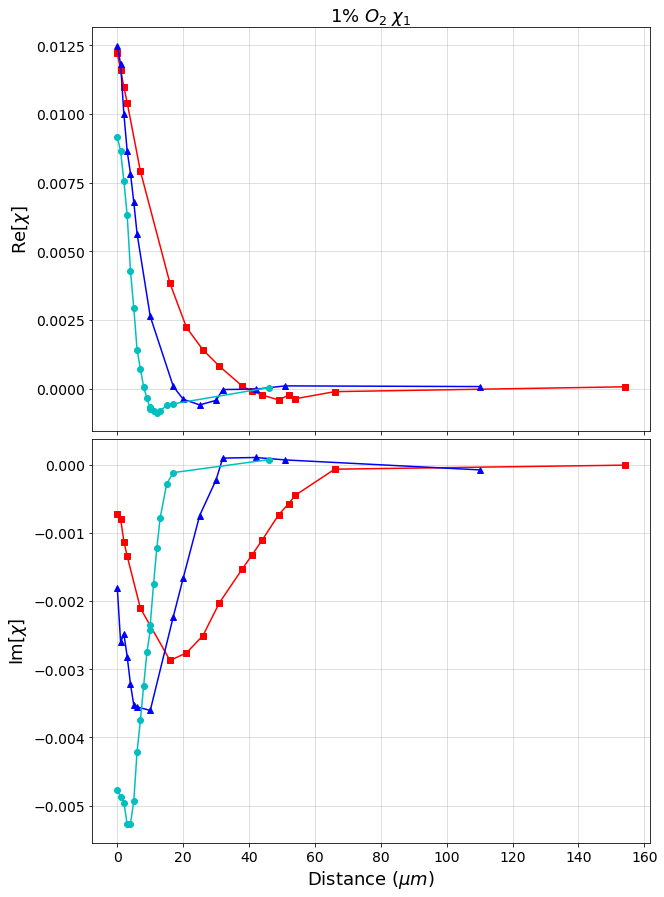

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
axes[0].set_title('1% $O_2 \; \chi_1$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Chi2 1%O2.png', dpi=400, bbox_inches='tight')

In [48]:
fit_params = Parameters()

for iy, data in enumerate(data1):
    fit_params.add(f'amp_{iy+1}', value=-data[0].real/.9, min=-1, max=-1e-3)
    fit_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    fit_params.add(f'ld_{iy+1}', value=15, min=1e-9, max=100)
    fit_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    fit_params.add(f'f_{iy+1}', value=frequencies[iy], vary=False)
    fit_params.add(f'L_{iy+1}', value=6e-1, vary=False)

# Setting other parameters within each dataset to be equal
t_1 = 4
t_10 = 8
t_100 = 11
for iy in np.arange(0, sizes[0]):
    if (iy+1) != t_1:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_1}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_1}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_1}'

for iy in np.arange(sizes[0], sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_10}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_10}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_10}'

for iy in np.arange(sum(sizes[:2]), len(data1)):
    if (iy+1) != t_100:
        fit_params[f'gammap_{iy+1}'].expr = f'gammap_{t_100}'
        fit_params[f'ld_{iy+1}'].expr = f'ld_{t_100}'
        fit_params[f'tg_{iy+1}'].expr = f'tg_{t_100}'

In [8]:
for iy in np.arange(1, sizes[0]):
    if (iy+1) != t_1:
        fit_params[f'amp_{iy+1}'].expr = f'amp_{t_1}'

for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params[f'amp_{iy+1}'].expr = f'amp_{t_10}'

for iy in np.arange(sum(sizes[:2])+1, len(data1)):
    if (iy+1) != t_100:
        fit_params[f'amp_{iy+1}'].expr = f'amp_{t_100}'

In [49]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data1, models.chi_patterned))

In [50]:
out = mini.minimize(method='leastsq')
# save_fit_report(f'..\\Fit Reports\\LeastSQ_F3_Pinned_Params_AmpDataInit.txt', out, starts)
print('\u03A7_red = ', out.redchi)
print(fit_report(out))

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Χ_red =  5.2542674695917705e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 282
    # data points      = 1022
    # variables        = 20
    chi-square         = 0.00526478
    reduced chi-square = 5.2543e-06
    Akaike info crit   = -12404.1106
    Bayesian info crit = -12305.5202
[[Variables]]
    amp_1:     -0.08834058 +/- 0.00267630 (3.03%) (init = -0.08497292)
    gammap_1:   0.05522778 +/- 0.03041628 (55.07%) == 'gammap_4'
    ld_1:       38.3792110 +/- 0.51650824 (1.35%) == 'ld_4'
    tg_1:       3.26089317 +/- 0.66382120 (20.36%) == 'tg_4'
    f_1:        0 (fixed)
    L_1:        0.6 (fixed)
    amp_2:     -0.01283537 +/- 0.00127894 (9.96%) (init = -0.01356824)
    gammap_2:   0.05522778 +/- 0.03041628 (55.07%) == 'gammap_4'
    ld_2:       38.3792110 +/- 0.51650824 (1.35%) == 'ld_4'
    tg_2:       3.26089317 +/- 0.66382120 (20.36%) == 'tg_4'
    f_2:        0.25 (fixed)
    L_2:        0.6 (fixed)
    amp_3:     -0.01442573 +/- 0.00166094 (1

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\lmfit\printfuncs.py:179: RuntimeWarning: invalid value encountered in long_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))


0.25 39.61761761761762 (-2.6984231612456615e-06-0.001889561541311586j) 9.862223817044184e-06
1 17.61761761761762 (-2.163851760026992e-05-0.0026816364174242382j) 9.99608854075387e-07
4 7.9659659659659665 (-1.0565887802240284e-05-0.0031100817385245846j) 5.2581993139794855e-06


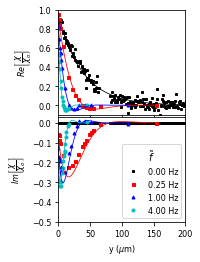

In [121]:
# DC scaling
DC_ind = 0
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
DC_norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(2.28, 3.90))

# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ms=3, ls='',
                       label=f'{frequencies[0]:.2f} Hz')

y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * DC_norm,
                       color=colors[0], marker='', lw=0.8)

for iy in np.arange(1,sizes[0]):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, x[iy], data1[iy] * f_norm, color=colors[iy],
                           marker=markers[iy], ms=3, ls='',
                           label=f'{frequencies[iy]:.2f} Hz')

zeros1 = []
for iy in np.arange(1,sizes[0]):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy], marker='', ms=3, lw=0.8, fontsize=8)
                           #label=str(frequencies[iy]) + ' Hz')
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros1.append(y_cross)
    print(out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))

axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 200)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
# axes[0].set_ylim(-0.0015, 0.014)
# axes[1].set_ylim(-.006, 0.0005)
axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.5, .03)
# axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.004))
axes[0].grid(False)
axes[1].grid(False)

axes[0].set_ylabel(r'$Re\left[\dfrac{\chi}{\chi_o}\right]$')
axes[1].set_ylabel(r'$Im\left[\dfrac{\chi}{\chi_o}\right]$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', fontsize=8)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Profiles\\1%O2_8.svg', dpi=400, bbox_inches='tight')

0.25 38.91891891891892 (-1.4543188572182811e-06-0.0008045803408189879j) 5.033617151824501e-05
1 15.255255255255255 (-7.176198742892275e-07-0.0017577047652577783j) 0.00011994414982764605
5 5.893893893893894 (-2.2593912658965334e-06-0.0017780484109591406j) 4.423890431115578e-06


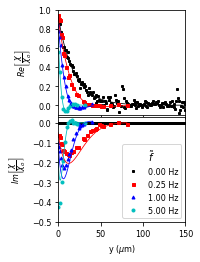

In [122]:
# DC scaling
DC_ind = sizes[0]
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
DC_norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(2.28, 3.90))

# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ms=3, ls='',
                       label=f'{frequencies[0]:.2f} Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * DC_norm,
                       color=colors[0], marker='', lw=0.8)

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, x[iy], data1[iy] * f_norm, color=colors[iy],
                           marker=markers[iy], ms=3,  ls='',
                           label=f'{frequencies[iy]:.2f} Hz')

zeros10 = []
for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    y = np.linspace(0, x[iy][-1], num=100)
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy], marker='', lw=0.8, fontsize=8)
                           #label=str(frequencies[iy]) + ' Hz Fit')
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros10.append(y_cross)
    print(out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))

axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_xlim(0, 150)
axes[1].set_xlim(0, 150)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
# axes[0].set_ylim(-0.001, 0.0115)
# axes[1].set_ylim(-.006, 0.0005)
axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.5, .03)

axes[0].grid(False)
axes[1].grid(False)

axes[0].set_ylabel(r'$Re\left[\dfrac{\chi}{\chi_o}\right]$')
axes[1].set_ylabel(r'$Im\left[\dfrac{\chi}{\chi_o}\right]$')
# axes[0].set_title('10% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', fontsize=8)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Profiles\\10%O2_6.svg', dpi=400, bbox_inches='tight')

0.5 32.46346346346346 (-1.6010086704514774e-09-9.568065211691752e-06j) 1.7306691207027996e-06
8 3.6061061061061057 (-4.77153715667557e-06-0.0013590097267264655j) 1.0215590134731644e-14


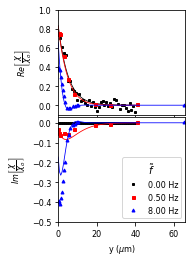

In [123]:
# DC scaling
DC_ind = sum(sizes[:2])
amp0 = 1
gamma_p0 = out.params[f'gammap_{DC_ind+2}']
ld0 = out.params[f'ld_{DC_ind+2}']
tg0 = out.params[f'tg_{DC_ind+2}']
L0 = out.params[f'L_{DC_ind+2}']
f0 = out.params[f'f_{DC_ind+2}']

norm = out.params[f'amp_{DC_ind+2}'] / out.params[f'amp_{DC_ind+1}']
DC_norm = -1 / out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(2.28, 3.90))


# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], data1[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ms=3, ls='',
                       label=f'{frequencies[0]:.2f} Hz')
y = np.linspace(0, x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, models.dataset_fun(out.params, DC_ind, y, models.chi_patterned) * DC_norm,
                       color=colors[0], marker='', lw=0.8)


for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, x[iy], data1[iy] * f_norm, color=colors[iy],
                           marker=markers[iy], ms=3, ls='', 
                           label=f'{frequencies[iy]:.2f} Hz')

zeros100 = []
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    f_norm = -1 / out.params[f'amp_{iy+1}']
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy], marker='', lw=0.8, fontsize=8)
                           #label=str(frequencies[iy]) + ' Hz Fit')
    y = np.linspace(0, x[iy][-1], num=1000)
    dum = models.dataset_fun(out.params, iy, y, models.chi_patterned)
    chi_cross = dum[np.sign(dum) == -1][0]
    y_cross = y[np.sign(dum) == -1][0]
    zeros100.append(y_cross)
    print(out.params[f'f_{iy+1}'].value, y_cross, chi_cross, np.min(np.abs(dum)))        

axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_xlim(0, 66)
axes[1].set_xlim(0, 66)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
# axes[0].set_ylim(-0.0019, 0.0165)
# axes[1].set_ylim(-.006, 0.0005)
axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.5, .03)

axes[0].grid(False)
axes[1].grid(False)

axes[0].set_ylabel(r'$Re\left[\dfrac{\chi}{\chi_o}\right]$')
axes[1].set_ylabel(r'$Im\left[\dfrac{\chi}{\chi_o}\right]$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$', fontsize=8)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Profiles\\100%O2_5.svg', dpi=400, bbox_inches='tight')

In [128]:
np.array(zeros100) / out.params['ld_11'].value

array([6.31988495, 0.70202539])

In [ ]:
zeros1 = np.array([39.62,17.62])